# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *


In [2]:
codes_list = ["BSM_XYY", "BSM_HAA", "SM_SIM"]

#codes_list = ["cmssim"]
uncut_data = {}
for code in codes_list:
    uncut_data[code] = np.load(f"compiled_data/{code}.npy")
    uncut_data[code] = np.nan_to_num(uncut_data[code])
    print(f"{code} has initial shape {uncut_data[code].shape}")

BSM_XYY has initial shape (35934, 9)
BSM_HAA has initial shape (388399, 9)
SM_SIM has initial shape (8800385, 9)


## Visualize the data

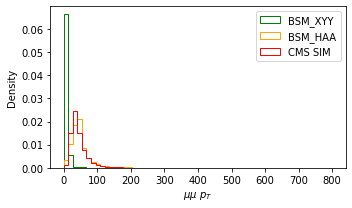

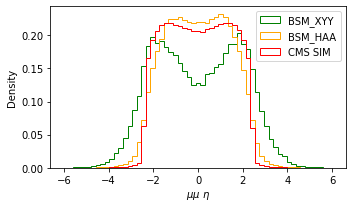

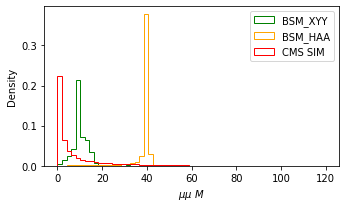

In [3]:
feature_set = [6, 7, 8]
    
hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype)
    


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [4]:
# jet_cuts

jet_pt_cut = 0 
jet_eta_cut = 10000


cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code][:,0] > jet_pt_cut) & (np.abs(uncut_data[code][:,1]) < jet_eta_cut) # MAKE SURE THE INDICES ARE OK
    cut_data[code] = uncut_data[code][pass_indices]
    print(f"{code} has shape {cut_data[code].shape} after cuts")
    

BSM_XYY has shape (26989, 9) after cuts
BSM_HAA has shape (388366, 9) after cuts
SM_SIM has shape (8800332, 9) after cuts


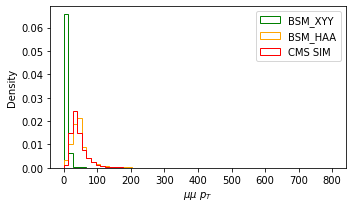

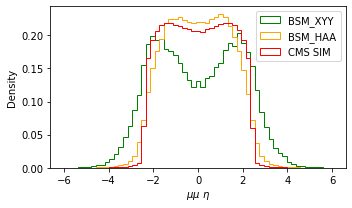

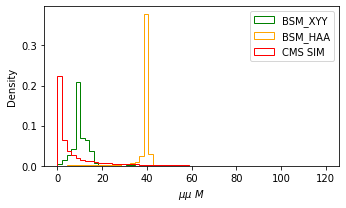

In [5]:
    
    
hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [6]:
band_bounds = {"SBL": [15, 28],
               "IBL": [28, 33],
               "SR": [33, 50],
               "IBH": [50, 55],
               "SBH": [55, 90],
                       }

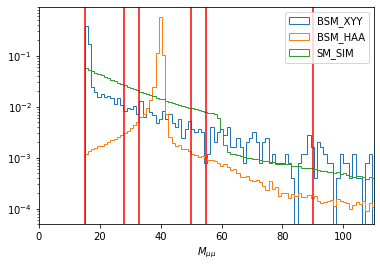

In [7]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code][:,-1], bins = np.linspace(15, 120, 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(0, 110)
plt.yscale("log")
plt.show()

In [8]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code][:,-1] > band_bounds[b][0]) & (cut_data[code][:,-1] < band_bounds[b][1])
        preproc_dicts[b][code] = cut_data[code][loc_pass_indices]

        print(f"{code} {b} has shape {preproc_dicts[b][code].shape}")
   
    
    

BSM_XYY SBL has shape (1761, 9)
BSM_XYY IBL has shape (105, 9)
BSM_XYY SR has shape (254, 9)
BSM_XYY IBH has shape (36, 9)
BSM_XYY SBH has shape (144, 9)
BSM_HAA SBL has shape (9481, 9)
BSM_HAA IBL has shape (7600, 9)
BSM_HAA SR has shape (355018, 9)
BSM_HAA IBH has shape (2087, 9)
BSM_HAA SBH has shape (5442, 9)
SM_SIM SBL has shape (839724, 9)
SM_SIM IBL has shape (185622, 9)
SM_SIM SR has shape (376114, 9)
SM_SIM IBH has shape (69108, 9)
SM_SIM SBH has shape (99608, 9)


In [9]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Signal injection


In [10]:
signal_model = "BSM_HAA"

N_bkg_SR_total = preproc_dicts["SR"]["SM_SIM"].shape[0]
N_sig_SR_total = preproc_dicts["SR"][signal_model].shape[0]

print(f"{N_bkg_SR_total} bkg in SR, {N_sig_SR_total} sig in SR")


376114 bkg in SR, 355018 sig in SR


In [11]:
# set aside some events for testing (also for full sup)
N_bkg_SR_test = 100000
N_sig_SR_test = 20000

N_bkg_SR_train = N_bkg_SR_total - N_bkg_SR_test
N_sig_SR_train = N_sig_SR_total - N_sig_SR_test

print(N_bkg_SR_train, N_sig_SR_train)

r_bkg = N_bkg_SR_train/N_bkg_SR_total

print("N_bkg_SR_train/N_bkg_SR_total", r_bkg)


276114 335018
N_bkg_SR_train/N_bkg_SR_total 0.7341231647851449


Because we set aside some events for a test set, the SR now effectively contains a reduced number of background events, as scaled by `r_bkg`.

If there were no test set, we would:

- Inject a certain number of events `N_sig_inject_SR` into the SR, calculated from the desired significance
- Calculate what fraction of the total number of signal events this represents, `N_sig_inject_SR/N_sig_SR_total`
- Inject this same fraction of the sig events we have in each band into the bkg in each band.

However, we must scale this fraction up by `r_bkg` to reflect the fact that we've removed some bkg events in the SR only

In [12]:
# calculate how many signal events to inject into the SR
desired_significance = 2
N_sig_inject_SR = int(np.sqrt(N_bkg_SR_train)*desired_significance)

frac_sig_to_inject_nonSR = N_sig_inject_SR/(N_sig_SR_total*r_bkg)
print(f"Frac inject in SR:", N_sig_inject_SR/(N_sig_SR_total), "frac inject out of SR:", frac_sig_to_inject_nonSR)

print(f"Attempting to inject {N_sig_inject_SR} events into the SR.")
print(f"Available signal event pool: {N_sig_SR_train}.")

print(f"Desired significance in SR: {desired_significance}, S/B in SR: {N_sig_inject_SR/N_bkg_SR_train}.")


Frac inject in SR: 0.00295759651623298 frac inject out of SR: 0.004028747025165152
Attempting to inject 1050 events into the SR.
Available signal event pool: 335018.
Desired significance in SR: 2, S/B in SR: 0.0038027771138008214.


In [13]:
num_signal_events_to_inject = {}

for b in bands:
    if b == "SR": 
        num_signal_events_to_inject[b] = N_sig_inject_SR
        #print(int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_model].shape[0]))
    else:
        num_signal_events_to_inject[b] = int(frac_sig_to_inject_nonSR*preproc_dicts[b][signal_model].shape[0])
    print(b, num_signal_events_to_inject[b])

SBL 38
IBL 30
SR 1050
IBH 8
SBH 21


In [14]:
# then do the injection

from sklearn.utils import shuffle

preproc_dicts_s_inj = {}

for b in bands:
    if b == "SR": 
        sig_events_to_inject_inds = np.random.choice(range(N_sig_SR_test, N_sig_SR_test+N_sig_SR_train), size=num_signal_events_to_inject[b], replace=False)
        sig_events_to_inject = preproc_dicts[b][signal_model][sig_events_to_inject_inds]
        band_data = np.vstack((preproc_dicts[b]["SM_SIM"][N_bkg_SR_test:], sig_events_to_inject))
    else:
        sig_events_to_inject_inds = np.random.choice(range(preproc_dicts[b][signal_model].shape[0]), size=num_signal_events_to_inject[b], replace=False)
        sig_events_to_inject = preproc_dicts[b][signal_model][sig_events_to_inject_inds]
        band_data = np.vstack((preproc_dicts[b]["SM_SIM"], sig_events_to_inject))
        
    preproc_dicts_s_inj[b] = shuffle(band_data)
    
# test sets
test_sets = {
    "bkg": preproc_dicts["SR"]["SM_SIM"][:N_bkg_SR_test],
    "sig": preproc_dicts["SR"][signal_model][:N_sig_SR_test]
}


## Preprocessing

Standard scaling is fine

In [15]:
save_scaler = True


In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

#rescale_feats = [5, 6, 7, 8, 9]
rescale_feats = [6]

proc_dict_s_inj = {b:{} for b in bands}


if save_scaler:
    SB_all = np.vstack((preproc_dicts_s_inj["SBL"], preproc_dicts_s_inj["SBH"]))
    scaler = StandardScaler()
    scaler = scaler.fit(SB_all)
    with open(f"processed_data/scaler", "wb") as ofile:
        pickle.dump(scaler, ofile)
else:
    with open(f"processed_data/scaler", "rb") as ifile:
        scaler = pickle.load(ifile)
    
for b in bands:
    proc_dict_s_inj[b]["s_inj_data"] = scaler.transform(preproc_dicts_s_inj[b])
    for ii in rescale_feats:
         proc_dict_s_inj[b]["s_inj_data"][:,ii] = (proc_dict_s_inj[b]["s_inj_data"][:,ii]-22)/6

# test sets
for key in test_sets.keys():
    test_sets[key] = scaler.transform(test_sets[key])
    for ii in rescale_feats:
        test_sets[key] [:,ii] = (test_sets[key] [:,ii]-22)/6

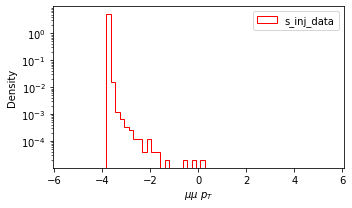

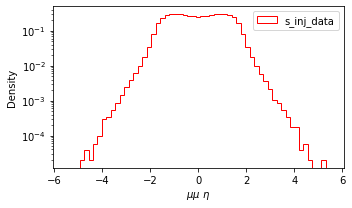

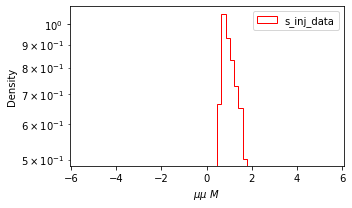

In [20]:
hist_all_features(["s_inj_data"], proc_dict_s_inj["SR"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


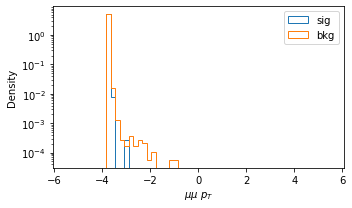

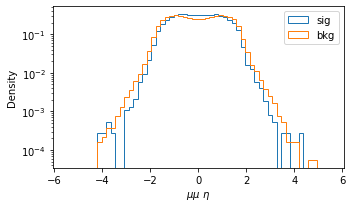

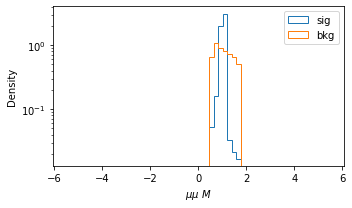

In [18]:
hist_all_features(["sig", "bkg"], test_sets, feature_set, {"sig":{"histtype":"step", "density":True, "label":"sig"}, "bkg":{"histtype":"step", "density":True, "label":"bkg"}}, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


In [19]:

for b in bands:
    np.save(f"processed_data/s_inj_{b}.npy", proc_dict_s_inj[b]["s_inj_data"])


N_bkg_SR_fullsup = 10000
N_sig_SR_fuppsup = 10000
    
    
for key in test_sets.keys():
    
    np.save(f"processed_data/full_sup_{key}.npy", test_sets[key][:N_bkg_SR_fullsup])
    np.save(f"processed_data/test_{key}.npy", test_sets[key][N_bkg_SR_fullsup:])
    
    print(test_sets[key][:N_bkg_SR_fullsup].shape, test_sets[key][N_bkg_SR_fullsup:].shape)
    

(10000, 9) (90000, 9)
(10000, 9) (10000, 9)
